In [2]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

import numpy as np
import matplotlib.pyplot as plt
from importlib import reload

import bemcs


In [3]:
def displacements_stresses_constant_linear(
    x,
    y,
    a,
    mu,
    nu,
    shape_function,
    element_type,
    x_component,
    y_component,
    x_center,
    y_center,
    rotation_matrix,
    inverse_rotation_matrix,
):
    """Calculate displacements and stresses for constant and linear slip elements"""
    # Rotate and translate into local coordinate system
    x = x - x_center
    y = y - y_center
    rotated_coords = np.matmul(np.vstack((x, y)).T, rotation_matrix)
    x = rotated_coords[:, 0]
    y = rotated_coords[:, 1]

    # Convert to global coordinates here.  Should this be elsewhere?
    global_components = inverse_rotation_matrix @ np.array([x_component, y_component])
    x_component = global_components[0]
    y_component = global_components[1]

    if shape_function == "constant":
        f = constant_kernel(x, y, a, nu)
    elif shape_function == "linear":
        f = linear_kernel(x, y, a, nu)

    if element_type == "traction":
        displacement, stress = f_traction_to_displacement_stress(
            x_component, y_component, f, y, mu, nu
        )
    elif element_type == "slip":
        displacement, stress = f_slip_to_displacement_stress(
            x_component, y_component, f, y, mu, nu
        )

    displacement, stress = rotate_displacement_stress(
        displacement, stress, inverse_rotation_matrix
    )
    return displacement, stress


def constant_kernel(x, y, a, nu):
    """From Starfield and Crouch, pages 49 and 82"""
    f = np.zeros((7, x.size))

    f[0, :] = (
        -1
        / (4 * np.pi * (1 - nu))
        * (
            y * (np.arctan2(y, (x - a)) - np.arctan2(y, (x + a)))
            - (x - a) * np.log(np.sqrt((x - a) ** 2 + y**2))
            + (x + a) * np.log(np.sqrt((x + a) ** 2 + y**2))
        )
    )

    f[1, :] = (
        -1
        / (4 * np.pi * (1 - nu))
        * ((np.arctan2(y, (x - a)) - np.arctan2(y, (x + a))))
    )

    f[2, :] = (
        1
        / (4 * np.pi * (1 - nu))
        * (
            np.log(np.sqrt((x - a) ** 2 + y**2))
            - np.log(np.sqrt((x + a) ** 2 + y**2))
        )
    )

    f[3, :] = (
        1
        / (4 * np.pi * (1 - nu))
        * (y / ((x - a) ** 2 + y**2) - y / ((x + a) ** 2 + y**2))
    )

    f[4, :] = (
        1
        / (4 * np.pi * (1 - nu))
        * ((x - a) / ((x - a) ** 2 + y**2) - (x + a) / ((x + a) ** 2 + y**2))
    )

    f[5, :] = (
        1
        / (4 * np.pi * (1 - nu))
        * (
            ((x - a) ** 2 - y**2) / ((x - a) ** 2 + y**2) ** 2
            - ((x + a) ** 2 - y**2) / ((x + a) ** 2 + y**2) ** 2
        )
    )

    f[6, :] = (
        2
        * y
        / (4 * np.pi * (1 - nu))
        * (
            (x - a) / ((x - a) ** 2 + y**2) ** 2
            - (x + a) / ((x + a) ** 2 + y**2) ** 2
        )
    )
    return f


def f_slip_to_displacement_stress(x_component, y_component, f, y, mu, nu):
    """This is the generalization from Starfield and Crouch"""
    displacement = np.zeros((2, y.size))
    stress = np.zeros((3, y.size))

    # The sign change here is to:
    # 1 - Ensure consistenty with Okada convention
    # 2 - For a horizontal/flat fault make the upper half move in the +x direction
    x_component = -1 * x_component
    y_component = -1 * y_component

    displacement[0, :] = x_component * (
        2 * (1 - nu) * f[1, :] - y * f[4, :]
    ) + y_component * (-1 * (1 - 2 * nu) * f[2, :] - y * f[3, :])

    displacement[1, :] = x_component * (
        (1 - 2 * nu) * f[2, :] - y * f[3, :]
    ) + y_component * (
        2 * (1 - nu) * f[1, :] - y * -f[4, :]
    )  # Note the negative sign in front f[4, :] because f[4, :] = f,xx = -f,yy

    stress[0, :] = 2 * x_component * mu * (
        2 * f[3, :] + y * f[5, :]
    ) + 2 * y_component * mu * (-f[4, :] + y * f[6, :])

    stress[1, :] = 2 * x_component * mu * (-y * f[5, :]) + 2 * y_component * mu * (
        -f[4, :] - y * f[6, :]
    )

    stress[2, :] = 2 * x_component * mu * (
        -f[4, :] + y * f[6, :]
    ) + 2 * y_component * mu * (-y * f[5, :])

    return displacement, stress


def rotate_displacement_stress(displacement, stress, inverse_rotation_matrix):
    """Rotate displacements stresses from local to global reference frame"""
    displacement = np.matmul(displacement.T, inverse_rotation_matrix).T
    for i in range(0, stress.shape[1]):
        stress_tensor = np.array(
            [[stress[0, i], stress[2, i]], [stress[2, i], stress[1, i]]]
        )
        stress_tensor_global = (
            inverse_rotation_matrix.T @ stress_tensor @ inverse_rotation_matrix
        )
        stress[0, i] = stress_tensor_global[0, 0]
        stress[1, i] = stress_tensor_global[1, 1]
        stress[2, i] = stress_tensor_global[0, 1]
    return displacement, stress

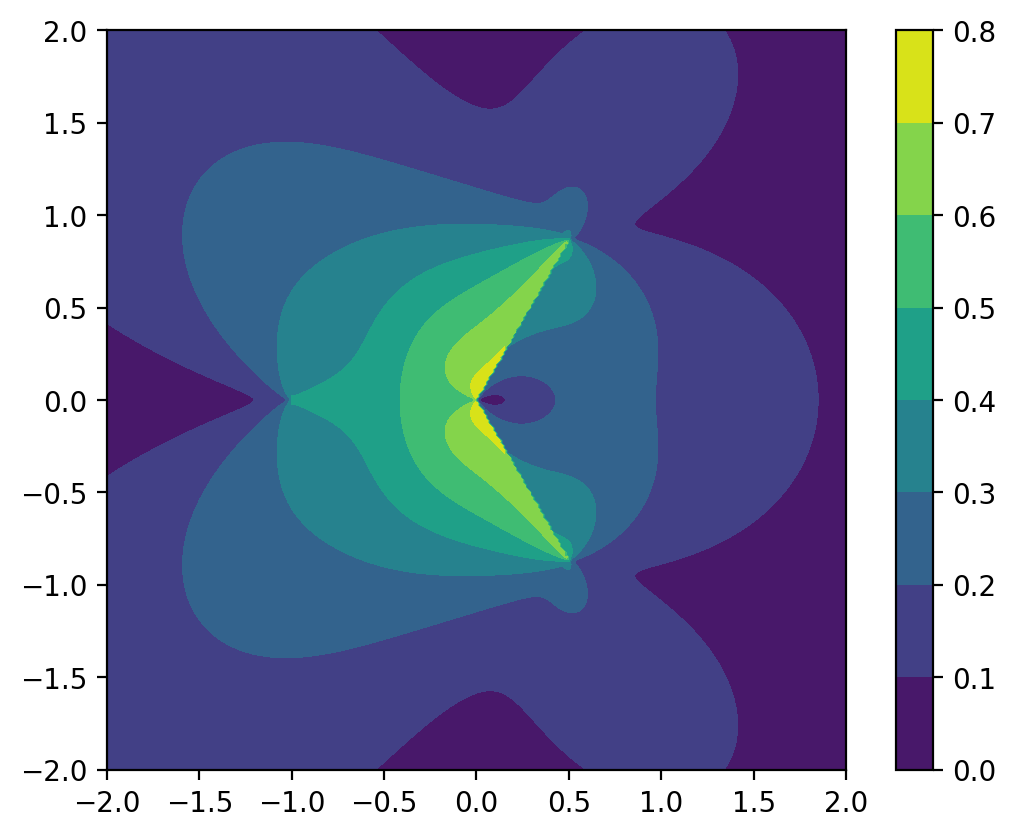

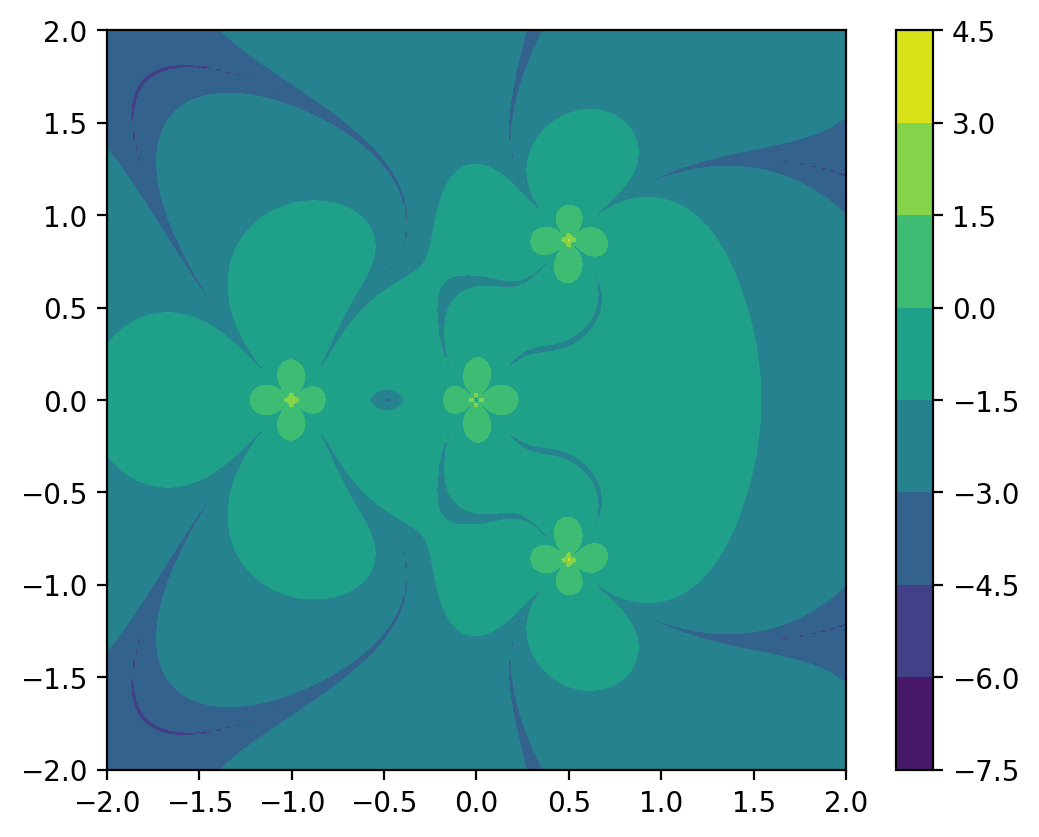

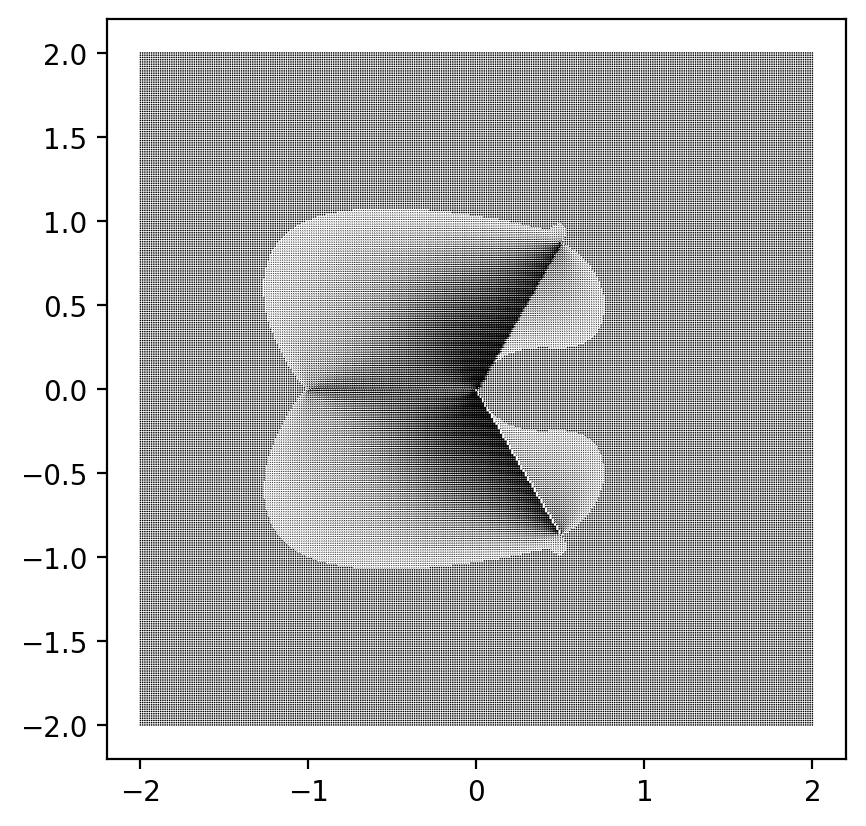

In [50]:
# Elastic parameters
mu = 1
nu = 0.25

# Triple junction geometry
els = bemcs.initialize_els()
els.x1 = np.array([-1.0, 0.0, 0.0])
els.x2 = np.array([0.0, np.cos(np.deg2rad(60)), np.cos(np.deg2rad(60))])
els.y1 = np.array([0.0, 0.0, 0.0])
els.y2 = np.array([0.0, np.sin(np.deg2rad(60)), -np.sin(np.deg2rad(60))])
bemcs.standardize_els_geometry(els)
n_els = len(els.x1)
# bemcs.plot_els_geometry(els)

# slip_x_vec = np.array([1.0, np.cos(np.deg2rad(60)), np.cos(np.deg2rad(60))])
# slip_y_vec = np.array([0.0, np.sin(np.deg2rad(60)), -np.sin(np.deg2rad(60))])

slip_x_vec = np.array([1.0, 1.0, 1.0])
slip_y_vec = np.array([0.0, 0.0, 0.0])


n_obs = 300
x_obs = np.linspace(-2.0, 2.0, n_obs)
y_obs = np.linspace(-2.0, 2.0, n_obs)
x_obs, y_obs = np.meshgrid(x_obs, y_obs)
x_obs = x_obs.flatten()
y_obs = y_obs.flatten()

i = 0
displacement_0, stress_0 = displacements_stresses_constant_linear(
    x_obs,
    y_obs,
    els.half_lengths[i],
    mu,
    nu,
    "constant",
    "slip",
    slip_x_vec[i],  # x-direction
    slip_y_vec[i],  # y-direction
    els.x_centers[i],
    els.y_centers[i],
    els.rot_mats[i, :, :],
    els.rot_mats_inv[i, :, :],
)

i = 1
displacement_1, stress_1 = displacements_stresses_constant_linear(
    x_obs,
    y_obs,
    els.half_lengths[i],
    mu,
    nu,
    "constant",
    "slip",
    slip_x_vec[i],  # x-direction
    slip_y_vec[i],  # y-direction
    els.x_centers[i],
    els.y_centers[i],
    els.rot_mats[i, :, :],
    els.rot_mats_inv[i, :, :],
)

i = 2
displacement_2, stress_2 = displacements_stresses_constant_linear(
    x_obs,
    y_obs,
    els.half_lengths[i],
    mu,
    nu,
    "constant",
    "slip",
    slip_x_vec[i],  # x-direction
    slip_y_vec[i],  # y-direction
    els.x_centers[i],
    els.y_centers[i],
    els.rot_mats[i, :, :],
    els.rot_mats_inv[i, :, :],
)


displacement_total = displacement_0 + displacement_1 + displacement_2
stress_total = stress_0 + stress_1 + stress_2

u_mag = np.sqrt(displacement_total[0, :] ** 2.0 + displacement_total[1, :] ** 2.0)
second_stress_invariant = (
    stress_total[0, :] * stress_total[1, :] - stress_total[2, :] ** 2.0
)

plt.figure()
plt.contourf(
    x_obs.reshape(n_obs, n_obs),
    y_obs.reshape(n_obs, n_obs),
    u_mag.reshape(n_obs, n_obs),
)
plt.gca().set_aspect("equal", adjustable="box")
plt.colorbar()
plt.show()

plt.figure()
plt.contourf(
    x_obs.reshape(n_obs, n_obs),
    y_obs.reshape(n_obs, n_obs),
    np.log10(np.abs(second_stress_invariant.reshape(n_obs, n_obs))),
)
plt.gca().set_aspect("equal", adjustable="box")
plt.colorbar()
plt.show()

plt.figure()
plt.quiver(x_obs, y_obs, displacement_total[0, :], displacement_total[1, :])
plt.gca().set_aspect("equal", adjustable="box")

plt.show()

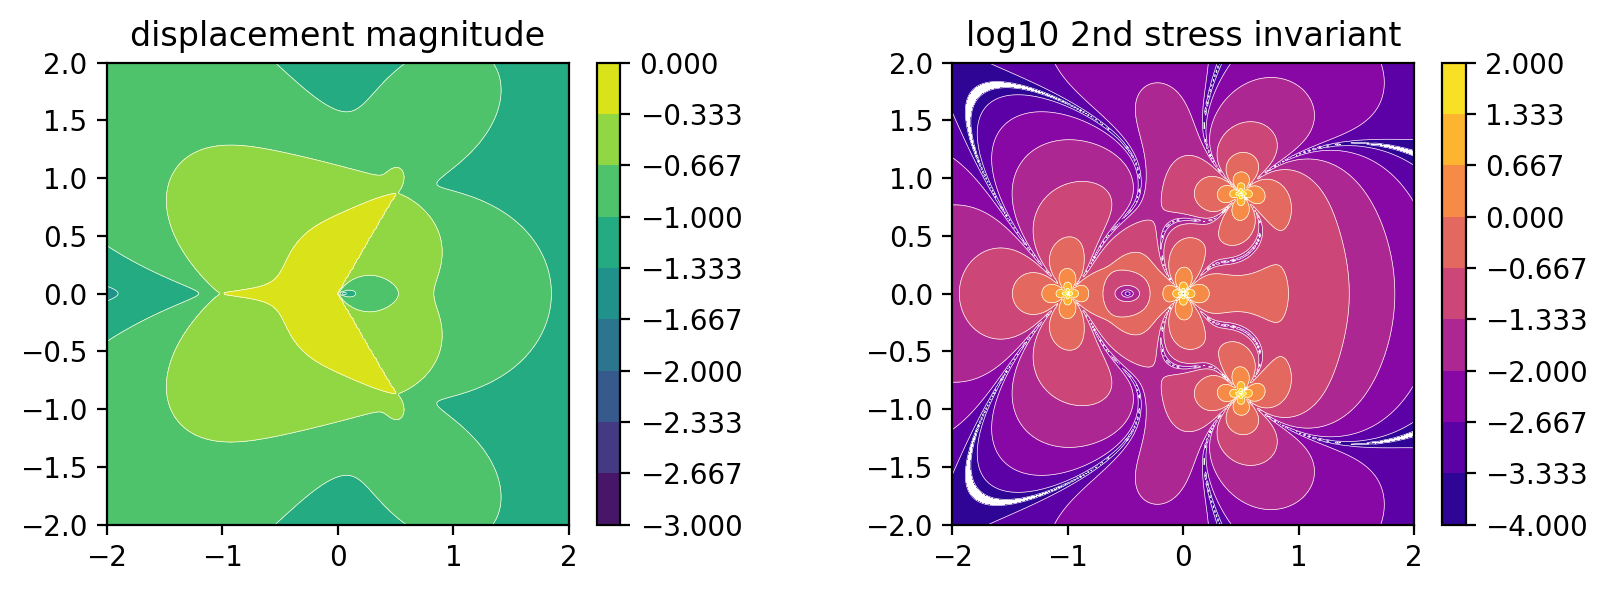

In [51]:
plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
levels = np.linspace(-3, 0, 10)
plt.title("displacement magnitude")
plt.contourf(
    x_obs.reshape(n_obs, n_obs),
    y_obs.reshape(n_obs, n_obs),
    np.log10(u_mag.reshape(n_obs, n_obs)),
    levels=levels,
)
plt.colorbar(fraction=0.046, pad=0.04)
plt.contour(
    x_obs.reshape(n_obs, n_obs),
    y_obs.reshape(n_obs, n_obs),
    np.log10(u_mag.reshape(n_obs, n_obs)),
    levels=levels,
    linewidths=0.25,
    linestyles="-",
    colors="w",
)
# plot_els(els)
plt.gca().set_aspect("equal", adjustable="box")

plt.subplot(1, 2, 2)
levels = np.linspace(-4, 2, 10)
plt.title("log10 2nd stress invariant")
plt.contourf(
    x_obs.reshape(n_obs, n_obs),
    y_obs.reshape(n_obs, n_obs),
    np.log10(np.abs(second_stress_invariant.reshape(n_obs, n_obs))),
    levels=levels,
    cmap="plasma",
)
plt.colorbar(fraction=0.046, pad=0.04)
plt.contour(
    x_obs.reshape(n_obs, n_obs),
    y_obs.reshape(n_obs, n_obs),
    np.log10(np.abs(second_stress_invariant.reshape(n_obs, n_obs))),
    levels=levels,
    linewidths=0.25,
    linestyles="-",
    colors="w",
)
# plot_els(els)
plt.gca().set_aspect("equal", adjustable="box")
plt.show()